In [1]:
import sys
sys.path.insert(1, '..')
sys.path.insert(2, '../modules/')
import drms
from ruffus import *
import os
import re
import pickle
import dataconfig
import warnings

warnings.filterwarnings("ignore")

from modules import convert_datetime
from modules import query_the_data
from modules import sxi_module
from modules import helio_reg_exp_module
from time import sleep
from random import randint
from astropy.time import Time
import sqlalchemy as sa
import pandas as pd

import random

import json

from datetime import datetime, timedelta

loaded libraries sxi module: 0:00:00.673109
loaded libraries sxi module: 0:00:00.000026


In [2]:
client = drms.Client()

In [3]:
def make_drms_ar_availability_filename_sharp(jsoc_query_str):

    sub2 = re.sub('hmi.sharp_720s\[', '', jsoc_query_str)

    sub3 = re.sub(' ','', sub2)

    sub4 = re.sub(']', '', sub3)

    sub5 = re.sub('\[', '', sub4)

    return(sub5)

In [4]:
def make_drms_ar_availability_filename_Mharp(jsoc_query_str):
    
    sub2 = re.sub('hmi.Mharp_720s\[', '', jsoc_query_str)

    sub3 = re.sub(' ','', sub2)

    sub4 = re.sub(']', '', sub3)

    sub5 = re.sub('\[', '', sub4)

    return(sub5)

In [5]:
def make_hmi_jsoc_availability_query_string_sharp(time_ex_1, time_ex_2):

    time_str_1 = f'{time_ex_1:%Y.%m.%d}'

    time_str_2 = f'{time_ex_2:%Y.%m.%d}'

    query_str = f'hmi.sharp_720s[][{time_str_1} - {time_str_2}]'

    return(query_str)

In [6]:
def make_hmi_jsoc_availability_query_string_Mharp(time_ex_1, time_ex_2):

    time_str_1 = f'{time_ex_1:%Y.%m.%d}'

    time_str_2 = f'{time_ex_2:%Y.%m.%d}'

    query_str = f'hmi.Mharp_720s[][{time_str_1} - {time_str_2}]'

    return(query_str)

In [7]:
def convert_TAI_to_UTC(TAI_STR):
    
    sub = re.sub('\.', '-',TAI_STR)

    sub2 = re.sub('_', 'T', sub)

    sub3 = re.sub('TTAI', '', sub2)

    t = Time(sub3, scale='tai')

    utc = t.utc

    pandas_timestamp = convert_datetime.astropytime_to_pythondatetime(utc)


    return(pandas_timestamp)

In [8]:
def test_same_dfs(harp_df, sharp_df):

    A = sharp_df[['LAT_MAX','LAT_MIN','LON_MAX','LON_MIN', 'HARPNUM']].reset_index(drop = True)
    B = harp_df[['LAT_MAX','LAT_MIN','LON_MAX','LON_MIN', 'HARPNUM']].dropna().reset_index(drop = True)


    diff = A[['LAT_MAX', 'LAT_MIN', 'LON_MAX', 'LON_MIN', 'HARPNUM']] - B[['LAT_MAX', 'LAT_MIN', 'LON_MAX', 'LON_MIN', 'HARPNUM']]

    non_zero_diff = diff[(diff != 0).any(axis=1)]

    return(len(non_zero_diff) == 0)

In [9]:
def if_test_ok_return_dfs(harp_df, sharp_df):

    A = sharp_df.reset_index(drop = True)
    B = harp_df.dropna().reset_index(drop = True)


    return(A,B)

In [10]:
def create_boundary_box_pixels(AR_DF_ROW):

    x_min, x_max, y_min, y_max = AR_DF_ROW.CRPIX1, AR_DF_ROW.CRPIX1 + AR_DF_ROW.CRSIZE1, AR_DF_ROW.CRPIX2, AR_DF_ROW.CRPIX2 + AR_DF_ROW.CRSIZE2

    list = [[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min], [x_min, y_min]]

    return(list)

In [11]:
def str_w_Z_at_end_to_pythondatetime(time_str):

    time_str_wo_Z = time_str[:-1]

    datetime_obj = datetime.strptime(time_str_wo_Z,'%Y-%m-%dT%H:%M:%S.%f' )

    return(pd.Timestamp(datetime_obj, tz = 'utc'))

In [12]:
def convert_columns_to_python_datetime(input_df):

    copy_df = input_df.copy()

    copy_df['T_OBS'] = [convert_TAI_to_UTC(tai_str) for tai_str in copy_df['T_OBS']]

    copy_df['T_FRST'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_FRST']]

    copy_df['T_FRST1'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_FRST1']]

    copy_df['T_LAST'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_LAST']]

    copy_df['T_LAST1'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_df['T_LAST1']]

    copy_df['DATE-OBS'] = [convert_datetime.str_w_Z_at_end_to_pythondatetime(this_z_str_datetime) for this_z_str_datetime in copy_df['DATE-OBS']]

    return(copy_df)

In [13]:
def convert_columns_to_UNIX_timestamp(input_df):

    copy_df = input_df.copy()

    copy_df['T_OBS'] = [convert_datetime.convert_datetime_to_timestamp(tai_str) for tai_str in copy_df['T_OBS']]

    copy_df['T_FRST'] = [convert_datetime.convert_datetime_to_timestamp(this_tai_str) for this_tai_str in copy_df['T_FRST']]

    copy_df['T_FRST1'] = [convert_datetime.convert_datetime_to_timestamp(this_tai_str) for this_tai_str in copy_df['T_FRST1']]

    copy_df['T_LAST'] = [convert_datetime.convert_datetime_to_timestamp(this_tai_str) for this_tai_str in copy_df['T_LAST']]

    copy_df['T_LAST1'] = [convert_datetime.convert_datetime_to_timestamp(this_tai_str) for this_tai_str in copy_df['T_LAST1']]

    copy_df['DATE-OBS'] = [convert_datetime.convert_datetime_to_timestamp(this_z_str_datetime) for this_z_str_datetime in copy_df['DATE-OBS']]

    return(copy_df)

In [14]:
def create_HGS_bbox(AR_DF_ROW):

    x_min, x_max, y_min, y_max = AR_DF_ROW.LON_MIN, AR_DF_ROW.LON_MAX, AR_DF_ROW.LAT_MIN, AR_DF_ROW.LAT_MAX

    list = [[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min], [x_min, y_min]]

    return(list)

In [15]:
start_download_from = '2014-08-01T00:00:00'
end_download_at = '2014-08-10T00:00:00'


START_DATE_TIME = pd.Timestamp(start_download_from, tz = 'utc')

END_DATE_TIME = pd.Timestamp(end_download_at, tz = 'utc')

frequency = '1D'

datelist = pd.date_range(start = START_DATE_TIME , end = END_DATE_TIME, freq = frequency ).tolist()

this_query_list_Mharp = [make_hmi_jsoc_availability_query_string_Mharp(previous,current) for previous,current in zip(datelist[:], datelist[1:])]

this_query_list_sharp = [make_hmi_jsoc_availability_query_string_sharp(previous,current) for previous,current in zip(datelist[:], datelist[1:])]


joint_list = [[m_harp_query, sharp_query] for m_harp_query, sharp_query in zip(this_query_list_Mharp,this_query_list_sharp)]

In [16]:
joint_list

[['hmi.Mharp_720s[][2014.08.01 - 2014.08.02]',
  'hmi.sharp_720s[][2014.08.01 - 2014.08.02]'],
 ['hmi.Mharp_720s[][2014.08.02 - 2014.08.03]',
  'hmi.sharp_720s[][2014.08.02 - 2014.08.03]'],
 ['hmi.Mharp_720s[][2014.08.03 - 2014.08.04]',
  'hmi.sharp_720s[][2014.08.03 - 2014.08.04]'],
 ['hmi.Mharp_720s[][2014.08.04 - 2014.08.05]',
  'hmi.sharp_720s[][2014.08.04 - 2014.08.05]'],
 ['hmi.Mharp_720s[][2014.08.05 - 2014.08.06]',
  'hmi.sharp_720s[][2014.08.05 - 2014.08.06]'],
 ['hmi.Mharp_720s[][2014.08.06 - 2014.08.07]',
  'hmi.sharp_720s[][2014.08.06 - 2014.08.07]'],
 ['hmi.Mharp_720s[][2014.08.07 - 2014.08.08]',
  'hmi.sharp_720s[][2014.08.07 - 2014.08.08]'],
 ['hmi.Mharp_720s[][2014.08.08 - 2014.08.09]',
  'hmi.sharp_720s[][2014.08.08 - 2014.08.09]'],
 ['hmi.Mharp_720s[][2014.08.09 - 2014.08.10]',
  'hmi.sharp_720s[][2014.08.09 - 2014.08.10]']]

In [17]:
jsoc_query_Mharp = joint_list[0] [0]

jsoc_query_sharp = joint_list[0][1]

jsoc_query_Mharp,jsoc_query_sharp


('hmi.Mharp_720s[][2014.08.01 - 2014.08.02]',
 'hmi.sharp_720s[][2014.08.01 - 2014.08.02]')

In [18]:
series_info_sharp = client.info("hmi.sharp_720s")
series_info_Mharp = client.info("hmi.Mharp_720s")


In [19]:
print(f"Listing keywords for {series_info_sharp.name}:\n")
for keyword in sorted(series_info_sharp.keywords.index):
    keyword_info = series_info_sharp.keywords.loc[keyword]
    print(keyword)
    print(f"  type ....... {keyword_info.type} ")
    print(f"  recscope ... {keyword_info.recscope} ")
    print(f"  defval ..... {keyword_info.defval} ")
    print(f"  units ...... {keyword_info.units} ")
    print(f"  note ....... {keyword_info.note} ")

Listing keywords for hmi.sharp_720s:

ABSNJZH
  type ....... float 
  recscope ... variable 
  defval ..... nan 
  units ...... (G^2)/m 
  note ....... Absolute value of the net current helicity 
ACTIVE
  type ....... int 
  recscope ... variable 
  defval ..... -2147483648 
  units ...... none 
  note ....... Mask value for active region pixels 
AMBBTHR0
  type ....... double 
  recscope ... variable 
  defval ..... nan 
  units ...... G 
  note ....... Transverse field strength threshold at disk center for using simulated annealing 
AMBBTHR1
  type ....... double 
  recscope ... variable 
  defval ..... nan 
  units ...... G 
  note ....... Transverse field strength threshold at limb for using simulated annealing 
AMBCODEV
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... Version of Disambig code 
AMBDOCU
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... Document for Disambig code 
A

In [20]:
print(f"Listing keywords for {series_info_Mharp.name}:\n")
for keyword in sorted(series_info_Mharp.keywords.index):
    keyword_info = series_info_Mharp.keywords.loc[keyword]
    print(keyword)
    print(f"  type ....... {keyword_info.type} ")
    print(f"  recscope ... {keyword_info.recscope} ")
    print(f"  defval ..... {keyword_info.defval} ")
    print(f"  units ...... {keyword_info.units} ")
    print(f"  note ....... {keyword_info.note} ")

Listing keywords for hmi.mharp_720s:

ACTIVE
  type ....... int 
  recscope ... variable 
  defval ..... -2147483648 
  units ...... none 
  note ....... Mask value for active region pixels 
AREA
  type ....... float 
  recscope ... variable 
  defval ..... nan 
  units ...... mH 
  note ....... De-projected area of patch on sphere in micro-hemisphere 
AREA_ACR
  type ....... float 
  recscope ... variable 
  defval ..... nan 
  units ...... mH 
  note ....... De-projected area of active pixels on sphere in micro-hemisphere 
ARMCODEV
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... ARmask code version 
ARMDOCU
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... ARmask code documentation 
ARM_BETA
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... ARmask parameter: Mask spatial smoothness 
ARM_EDGE
  type ....... float 
  recscope ... var

In [21]:
# keys_Mharp = 'CRPIX1, CRPIX2, CRSIZE1, CRSIZE2, T_OBS, HARPNUM,  AREA_ACR, QUALITY,NOAA_NUM, NOAA_AR, NOAA_ARS,AREA, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX,T_FRST,T_LAST'
# keys_sharp = 'T_OBS, HARPNUM,  AREA_ACR, QUALITY,NOAA_NUM, NOAA_AR, NOAA_ARS,AREA, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX,T_FRST,T_LAST'


In [22]:
keys_Mharp = 'AREA,CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,DATE-OBS,HARPNUM,LAT_MAX,LAT_MIN,LON_MAX,LON_MIN,NOAA_AR,NOAA_ARS,NOAA_NUM,NPIX,QUALITY,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,T_REC, DSUN_REF,DSUN_OBS,RSUN_REF,RSUN_OBS '

In [23]:
keys_sharp = 'CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,DATE-OBS,HARPNUM,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,NOAA_AR,NOAA_ARS,NOAA_NUM,LAT_MAX,LAT_MIN,LON_MAX,LON_MIN,ABSNJZH,AREA_ACR,TOTPOT,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,MEANPOT,MEANGAM,MEANGBH,MEANALP,MEANGBT,MEANGBZ,MEANJZD,MEANJZH,MEANSHR,R_VALUE,SHRGT45'


In [24]:
hmi_ar_query_df_sharp = client.query(jsoc_query_sharp, key= keys_sharp)
hmi_ar_query_df_sharp


,CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,DATE-OBS,HARPNUM,T_FRST,T_FRST1,T_LAST,...,MEANGAM,MEANGBH,MEANALP,MEANGBT,MEANGBZ,MEANJZD,MEANJZH,MEANSHR,R_VALUE,SHRGT45
0,0.504361,0.504361,180.013611,1633.482056,331.101318,2014-07-31T23:58:24.90Z,4379,2014.07.20_20:36:00_TAI,2014.07.21_11:48:00_TAI,2014.08.04_10:24:00_TAI,...,30.206,38.733,-0.002096,94.606,95.816,-0.121096,-0.000611,25.726,3.474,7.093
1,0.504362,0.504362,180.013489,1635.456177,331.135010,2014-08-01T00:10:24.90Z,4379,2014.07.20_20:36:00_TAI,2014.07.21_11:48:00_TAI,2014.08.04_10:24:00_TAI,...,29.776,38.279,-0.001826,94.564,95.608,-0.101675,-0.000532,25.290,3.708,6.049
2,0.504362,0.504362,180.013397,1637.442505,331.182861,2014-08-01T00:22:25.00Z,4379,2014.07.20_20:36:00_TAI,2014.07.21_11:48:00_TAI,2014.08.04_10:24:00_TAI,...,29.603,37.984,-0.001865,93.800,94.887,-0.129944,-0.000541,25.020,3.571,6.012
3,0.504361,0.504361,180.013397,1639.459961,332.163086,2014-08-01T00:34:25.00Z,4379,2014.07.20_20:36:00_TAI,2014.07.21_11:48:00_TAI,2014.08.04_10:24:00_TAI,...,29.431,37.788,-0.001757,93.174,94.087,-0.097163,-0.000508,24.904,3.247,5.641
4,0.504362,0.504362,180.013321,1640.463379,332.148438,2014-08-01T00:46:25.00Z,4379,2014.07.20_20:36:00_TAI,2014.07.21_11:48:00_TAI,2014.08.04_10:24:00_TAI,...,29.237,37.472,-0.001673,92.907,93.623,-0.071292,-0.000481,24.600,3.454,5.343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0.504364,0.504364,180.013397,160.872681,-142.020996,2014-08-01T23:10:24.90Z,4428,2014.07.31_17:36:00_TAI,2014.08.01_17:36:00_TAI,2014.08.03_23:24:00_TAI,...,30.803,65.322,0.010811,129.162,139.744,0.122758,0.002523,16.963,0.000,0.000
1635,0.504364,0.504364,180.013550,164.872681,-141.956299,2014-08-01T23:22:24.90Z,4428,2014.07.31_17:36:00_TAI,2014.08.01_17:36:00_TAI,2014.08.03_23:24:00_TAI,...,32.283,63.256,-0.006080,137.754,145.921,0.073131,-0.001398,16.924,0.000,0.000
1636,0.504363,0.504363,180.013474,167.901978,-141.931641,2014-08-01T23:34:24.90Z,4428,2014.07.31_17:36:00_TAI,2014.08.01_17:36:00_TAI,2014.08.03_23:24:00_TAI,...,32.441,62.895,0.002517,141.864,154.504,0.079447,0.000582,15.906,0.000,0.000
1637,0.504362,0.504362,180.013504,171.917969,-141.941650,2014-08-01T23:46:24.90Z,4428,2014.07.31_17:36:00_TAI,2014.08.01_17:36:00_TAI,2014.08.03_23:24:00_TAI,...,31.834,67.479,-0.016055,146.149,158.329,-0.105094,-0.004166,17.246,0.000,0.000


In [25]:
hmi_ar_query_df_sharp.HARPNUM.unique()

array([4379, 4383, 4390, 4392, 4396, 4397, 4398, 4399, 4413, 4414, 4418,
       4421, 4422, 4423, 4424, 4425, 4428])

In [26]:
hmi_ar_query_df_mharp = client.query(jsoc_query_Mharp, key= keys_Mharp)
hmi_ar_query_df_mharp

,AREA,CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,DATE-OBS,HARPNUM,...,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,T_REC,DSUN_REF,DSUN_OBS,RSUN_REF,RSUN_OBS
0,6792.682617,0.504361,0.504361,180.013611,401.0,1724.0,550,471,2014-07-31T23:58:24.90Z,4379,...,2014.07.20_20:36:00_TAI,2014.07.21_11:48:00_TAI,2014.08.04_10:24:00_TAI,2014.08.03_10:24:00_TAI,2014.08.01_00:00:07_TAI,2014.08.01_00:00:00_TAI,1.495979e+11,1.518291e+11,696000000.0,945.541992
1,6783.154785,0.504362,0.504362,180.013489,399.0,1724.0,549,471,2014-08-01T00:10:24.90Z,4379,...,2014.07.20_20:36:00_TAI,2014.07.21_11:48:00_TAI,2014.08.04_10:24:00_TAI,2014.08.03_10:24:00_TAI,2014.08.01_00:12:07_TAI,2014.08.01_00:12:00_TAI,1.495979e+11,1.518307e+11,696000000.0,945.532043
2,6773.770508,0.504362,0.504362,180.013397,397.0,1724.0,548,471,2014-08-01T00:22:25.00Z,4379,...,2014.07.20_20:36:00_TAI,2014.07.21_11:48:00_TAI,2014.08.04_10:24:00_TAI,2014.08.03_10:24:00_TAI,2014.08.01_00:24:07_TAI,2014.08.01_00:24:00_TAI,1.495979e+11,1.518324e+11,696000000.0,945.521667
3,6767.509766,0.504361,0.504361,180.013397,395.0,1723.0,547,472,2014-08-01T00:34:25.00Z,4379,...,2014.07.20_20:36:00_TAI,2014.07.21_11:48:00_TAI,2014.08.04_10:24:00_TAI,2014.08.03_10:24:00_TAI,2014.08.01_00:36:07_TAI,2014.08.01_00:36:00_TAI,1.495979e+11,1.518340e+11,696000000.0,945.511292
4,6758.776855,0.504362,0.504362,180.013321,394.0,1723.0,545,471,2014-08-01T00:46:25.00Z,4379,...,2014.07.20_20:36:00_TAI,2014.07.21_11:48:00_TAI,2014.08.04_10:24:00_TAI,2014.08.03_10:24:00_TAI,2014.08.01_00:48:07_TAI,2014.08.01_00:48:00_TAI,1.495979e+11,1.518358e+11,696000000.0,945.500610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,121.559540,0.504364,0.504364,180.013397,1874.0,2197.0,97,54,2014-08-01T23:10:24.90Z,4428,...,2014.07.31_17:36:00_TAI,2014.08.01_17:36:00_TAI,2014.08.03_23:24:00_TAI,2014.08.02_23:24:00_TAI,2014.08.01_23:12:07_TAI,2014.08.01_23:12:00_TAI,1.495979e+11,1.518035e+11,696000000.0,945.701355
2053,123.900345,0.504364,0.504364,180.013550,1870.0,2197.0,97,55,2014-08-01T23:22:24.90Z,4428,...,2014.07.31_17:36:00_TAI,2014.08.01_17:36:00_TAI,2014.08.03_23:24:00_TAI,2014.08.02_23:24:00_TAI,2014.08.01_23:24:07_TAI,2014.08.01_23:24:00_TAI,1.495979e+11,1.518049e+11,696000000.0,945.692505
2054,123.963684,0.504363,0.504363,180.013474,1867.0,2197.0,97,55,2014-08-01T23:34:24.90Z,4428,...,2014.07.31_17:36:00_TAI,2014.08.01_17:36:00_TAI,2014.08.03_23:24:00_TAI,2014.08.02_23:24:00_TAI,2014.08.01_23:36:07_TAI,2014.08.01_23:36:00_TAI,1.495979e+11,1.518064e+11,696000000.0,945.683411
2055,125.120346,0.504362,0.504362,180.013504,1863.0,2197.0,97,55,2014-08-01T23:46:24.90Z,4428,...,2014.07.31_17:36:00_TAI,2014.08.01_17:36:00_TAI,2014.08.03_23:24:00_TAI,2014.08.02_23:24:00_TAI,2014.08.01_23:48:07_TAI,2014.08.01_23:48:00_TAI,1.495979e+11,1.518079e+11,696000000.0,945.673889


In [27]:
hmi_ar_query_df_mharp.HARPNUM.unique()

array([4379, 4383, 4390, 4392, 4396, 4397, 4398, 4399, 4413, 4414, 4418,
       4421, 4422, 4423, 4424, 4425, 4428])

In [28]:
are_dimensions_of_dfs_the_same = test_same_dfs(hmi_ar_query_df_mharp,hmi_ar_query_df_sharp)

if are_dimensions_of_dfs_the_same:

    sharp_df, harp_df = if_test_ok_return_dfs(hmi_ar_query_df_mharp,hmi_ar_query_df_sharp)

    print('dropping Nans from m_harp give the same df as sharp')

if are_dimensions_of_dfs_the_same == False:

    print('dataframes not comparable for {}')

dropping Nans from m_harp give the same df as sharp


In [29]:
def join_dataframes(sharp_df, harp_df):

    """
    Make pixel bbox from harp_df: CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2
    Make hgs bbox from sharp_df: 

    keep_keys_sharp = 'DATE-OBS,HARPNUM,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,NOAA_AR,
                       NOAA_ARS,NOAA_NUM,LAT_MAX,LAT_MIN,LON_MAX,LON_MIN,ABSNJZH,AREA_ACR,
                       TOTPOT,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,MEANPOT,MEANGAM,MEANGBH,MEANALP,
                       MEANGBT,MEANGBZ,MEANJZD,MEANJZH,MEANSHR,R_VALUE,SHRGT45'

    keep_keys_Mharp = 'CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,NPIX, QUALITY,T_REC'
    
    """

    keep_keys_sharp = ['DATE-OBS','HARPNUM','T_FRST','T_FRST1','T_LAST','T_LAST1','T_OBS','NOAA_AR',
                       'NOAA_ARS','NOAA_NUM','LAT_MAX','LAT_MIN','LON_MAX','LON_MIN','ABSNJZH','AREA_ACR',
                       'TOTPOT','TOTUSJH','TOTUSJZ','SAVNCPP','USFLUX','MEANPOT','MEANGAM','MEANGBH','MEANALP',
                       'MEANGBT','MEANGBZ','MEANJZD','MEANJZH','MEANSHR','R_VALUE','SHRGT45']

    keep_keys_Mharp = ['CDELT1','CDELT2','CROTA2','CRPIX1','CRPIX2','CRSIZE1','CRSIZE2','NPIX', 'QUALITY','T_REC', 'DSUN_REF','DSUN_OBS','RSUN_REF','RSUN_OBS']

    masked_sharp = sharp_df[keep_keys_sharp]

    masked_mharp = harp_df[keep_keys_Mharp]

    return(pd.concat([masked_sharp,masked_mharp], axis = 1))


    



In [30]:
joined_sharp_mharp_df = join_dataframes(sharp_df, harp_df)

In [31]:
joined_copy = joined_sharp_mharp_df.copy()

joined_copy['hgs_bbox'] = [create_HGS_bbox(row) for row in joined_copy.itertuples()]

joined_copy['pixel_bbox'] = [create_boundary_box_pixels(row) for row in joined_copy.itertuples()]

In [32]:
joined_date_time = convert_columns_to_python_datetime(joined_copy)

In [33]:
joined_time_stamp = convert_columns_to_UNIX_timestamp(joined_date_time)

In [34]:
joined_time_stamp['NOAA_ARS'] = [re.split(r',',this_str_list) for this_str_list in joined_time_stamp['NOAA_ARS']]

In [35]:
joined_time_stamp

,DATE-OBS,HARPNUM,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,NOAA_AR,NOAA_ARS,NOAA_NUM,...,CRSIZE2,NPIX,QUALITY,T_REC,DSUN_REF,DSUN_OBS,RSUN_REF,RSUN_OBS,hgs_bbox,pixel_bbox
0,1.406851e+09,4379,1.405889e+09,1.405943e+09,1.407148e+09,1.407061e+09,1.406851e+09,12121,[12121],1,...,471,98430.0,0,2014.08.01_00:00:00_TAI,1.495979e+11,1.518291e+11,696000000.0,945.541992,"[[38.109142, 2.55276], [38.109142, 11.704672],...","[[401.0, 1724.0], [401.0, 2195.0], [951.0, 219..."
1,1.406852e+09,4379,1.405889e+09,1.405943e+09,1.407148e+09,1.407061e+09,1.406852e+09,12121,[12121],1,...,471,98052.0,0,2014.08.01_00:12:00_TAI,1.495979e+11,1.518307e+11,696000000.0,945.532043,"[[38.225826, 2.566468], [38.225826, 11.697543]...","[[399.0, 1724.0], [399.0, 2195.0], [948.0, 219..."
2,1.406853e+09,4379,1.405889e+09,1.405943e+09,1.407148e+09,1.407061e+09,1.406853e+09,12121,[12121],1,...,471,97677.0,0,2014.08.01_00:24:00_TAI,1.495979e+11,1.518324e+11,696000000.0,945.521667,"[[38.343136, 2.572173], [38.343136, 11.695191]...","[[397.0, 1724.0], [397.0, 2195.0], [945.0, 219..."
3,1.406853e+09,4379,1.405889e+09,1.405943e+09,1.407148e+09,1.407061e+09,1.406853e+09,12121,[12121],1,...,472,97343.0,0,2014.08.01_00:36:00_TAI,1.495979e+11,1.518340e+11,696000000.0,945.511292,"[[38.451782, 2.579014], [38.451782, 11.695137]...","[[395.0, 1723.0], [395.0, 2195.0], [942.0, 219..."
4,1.406854e+09,4379,1.405889e+09,1.405943e+09,1.407148e+09,1.407061e+09,1.406854e+09,12121,[12121],1,...,471,96970.0,0,2014.08.01_00:48:00_TAI,1.495979e+11,1.518358e+11,696000000.0,945.500610,"[[38.570007, 2.574831], [38.570007, 11.694263]...","[[394.0, 1723.0], [394.0, 2194.0], [939.0, 219..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,1.406935e+09,4428,1.406828e+09,1.406915e+09,1.407108e+09,1.407022e+09,1.406935e+09,0,[MISSING],0,...,54,2669.0,0,2014.08.01_23:12:00_TAI,1.495979e+11,1.518035e+11,696000000.0,945.701355,"[[2.259248, -0.018558], [2.259248, 1.212346], ...","[[1874.0, 2197.0], [1874.0, 2251.0], [1971.0, ..."
1635,1.406935e+09,4428,1.406828e+09,1.406915e+09,1.407108e+09,1.407022e+09,1.406935e+09,0,[MISSING],0,...,55,2720.0,0,2014.08.01_23:24:00_TAI,1.495979e+11,1.518049e+11,696000000.0,945.692505,"[[2.351036, -0.016472], [2.351036, 1.214945], ...","[[1870.0, 2197.0], [1870.0, 2252.0], [1967.0, ..."
1636,1.406936e+09,4428,1.406828e+09,1.406915e+09,1.407108e+09,1.407022e+09,1.406936e+09,0,[MISSING],0,...,55,2721.0,0,2014.08.01_23:36:00_TAI,1.495979e+11,1.518064e+11,696000000.0,945.683411,"[[2.474283, -0.01547], [2.474283, 1.2161], [4....","[[1867.0, 2197.0], [1867.0, 2252.0], [1964.0, ..."
1637,1.406937e+09,4428,1.406828e+09,1.406915e+09,1.407108e+09,1.407022e+09,1.406937e+09,0,[MISSING],0,...,55,2746.0,0,2014.08.01_23:48:00_TAI,1.495979e+11,1.518079e+11,696000000.0,945.673889,"[[2.566563, -0.015349], [2.566563, 1.21634], [...","[[1863.0, 2197.0], [1863.0, 2252.0], [1960.0, ..."


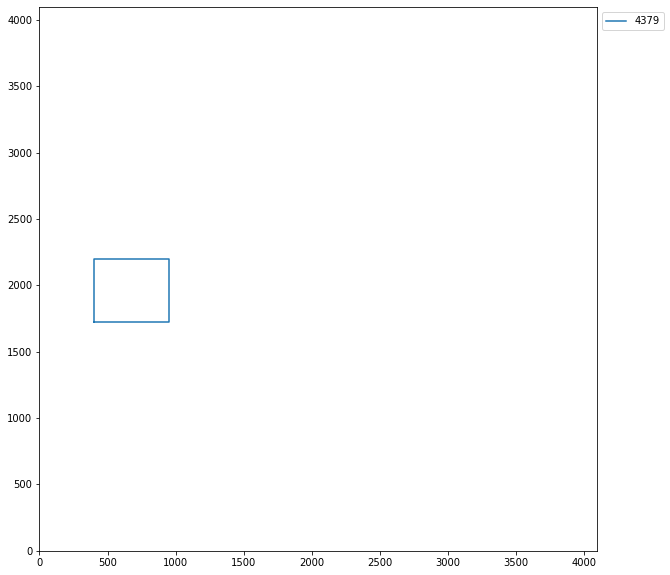

In [36]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

ax.set_ylim(0,4096)
ax.set_xlim(0,4096)

for harp_num, group in joined_time_stamp[:1].groupby(['HARPNUM']):

    for _, row in group.iloc[:1].iterrows():

        array_bbox = np.array(row.pixel_bbox)

        ax.plot(array_bbox[:,0], array_bbox[:,1], label = harp_num)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

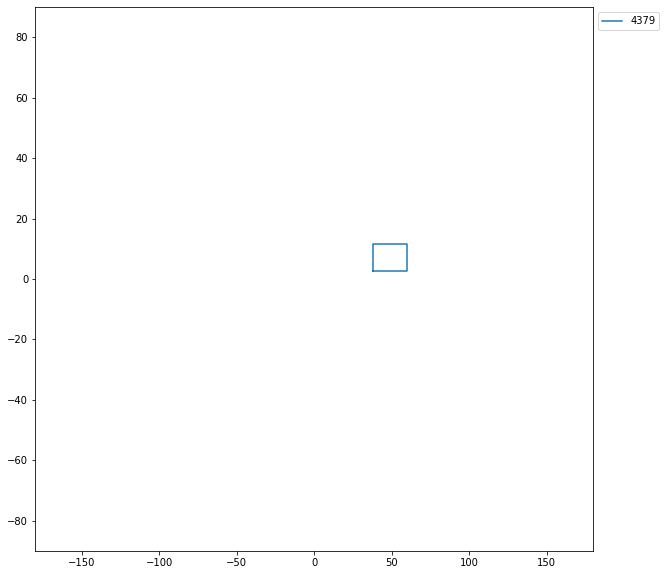

In [37]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)


ax.set_ylim(-90,90)
ax.set_xlim(-180,180)


for harp_num, group in joined_time_stamp[:1].groupby(['HARPNUM']):

    for _, row in group.iloc[:1].iterrows():

        array_bbox = np.array(row.hgs_bbox)

        ax.plot(array_bbox[:,0], array_bbox[:,1], label = harp_num)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [38]:
import numpy as np

def get_pixel_boundary_box(row):
    """
    Returns the pixel boundary box for an image using metadata from the Mharp data series.
    
    Parameters:
    - CDELT1 (float): Pixel scale in the x-direction (arcseconds per pixel)
    - CDELT2 (float): Pixel scale in the y-direction (arcseconds per pixel)
    - CROTA2 (float): Rotation angle (degrees)
    - CRPIX1 (float): Reference pixel in the x-direction (usually the center)
    - CRPIX2 (float): Reference pixel in the y-direction (usually the center)
    - CRSIZE1 (float): Number of pixels in the x-direction (width)
    - CRSIZE2 (float): Number of pixels in the y-direction (height)
    
    Returns:
    - A tuple (x_left, x_right, y_bottom, y_top) representing the pixel boundary box.
    """
    # print(row)
    CDELT1, CDELT2, CROTA2, CRPIX1, CRPIX2, CRSIZE1, CRSIZE2 = row['CDELT1'],row['CDELT2'], row['CROTA2'], row['CRPIX1'], row['CRPIX2'], row['CRSIZE1'], row['CRSIZE2']
    
    # Compute the unrotated boundary box in pixel space
    x_left = CRPIX1 - CRSIZE1 / 2
    x_right = CRPIX1 + CRSIZE1 / 2
    y_bottom = CRPIX2 - CRSIZE2 / 2
    y_top = CRPIX2 + CRSIZE2 / 2

    # Boundary corners in pixel space (before rotation)
    corners = np.array([
        [x_left, y_bottom],
        [x_right, y_bottom],
        [x_right, y_top],
        [x_left, y_top]
    ])

    # Convert the rotation angle from degrees to radians
    theta = np.deg2rad(CROTA2)

    # Rotation matrix
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    # Apply the rotation if CROTA2 is not zero
    if CROTA2 != 0:
        # Translate the corners to the origin (relative to CRPIX1, CRPIX2)
        translated_corners = corners - np.array([CRPIX1, CRPIX2])

        # Rotate the corners around the reference pixel
        rotated_corners = np.dot(translated_corners, rotation_matrix.T)

        # Translate back to the original position
        rotated_corners += np.array([CRPIX1, CRPIX2])

        # Get the rotated boundaries
        x_min, x_max = np.min(rotated_corners[:, 0]), np.max(rotated_corners[:, 0])
        y_min, y_max = np.min(rotated_corners[:, 1]), np.max(rotated_corners[:, 1])

    
    this_list = [[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min], [x_min, y_min]]

    return (this_list)

In [57]:
joined_time_stamp['pixel_bbox_2'] = [get_pixel_boundary_box(row) for _,row in joined_copy.iterrows()]

joined_time_stamp.hgs_bbox.iloc[0], joined_time_stamp.CROTA2.iloc[0], joined_time_stamp.RSUN_OBS.iloc[0]

joined_time_stamp[['hgs_bbox', 'CROTA2', 'RSUN_OBS', 'CDELT1']].iloc[0]

hgs_bbox    [[38.109142, 2.55276], [38.109142, 11.704672],...
CROTA2                                             180.013611
RSUN_OBS                                           945.541992
CDELT1                                               0.504361
Name: 0, dtype: object

In [64]:
crota2, rsun, cdelt1, crsize1, crsize2 = joined_time_stamp[ ['CROTA2', 'RSUN_OBS', 'CDELT1', 'CRSIZE1', 'CRSIZE2']].iloc[0]

np.abs(crsize1*np.cos(crota2)- crsize2*np.sin(crota2))*cdelt1

29.262597117093758

In [65]:
abs(crsize2* np.cos(crota2)+ crsize1* np.sin(crota2))*cdelt1

364.0406208054454

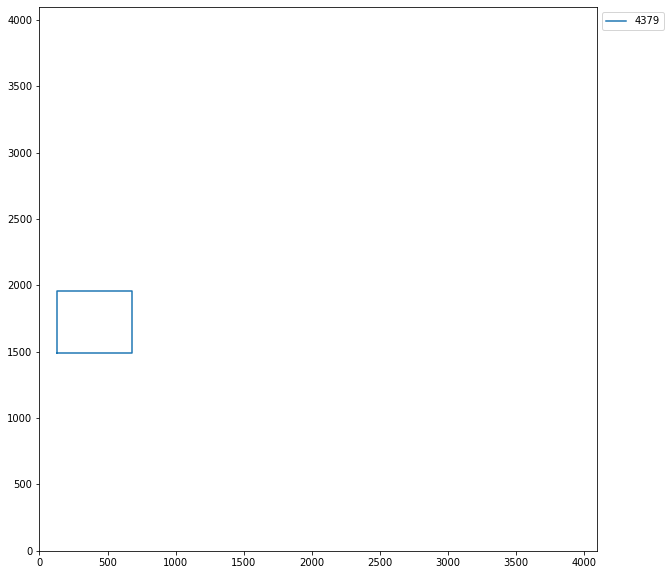

In [40]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

ax.set_ylim(0,4096)
ax.set_xlim(0,4096)

for harp_num, group in joined_time_stamp[:1].groupby(['HARPNUM']):

    for _, row in group.iloc[:1].iterrows():

        array_bbox = np.array(row.pixel_bbox_2)

        ax.plot(array_bbox[:,0], array_bbox[:,1], label = harp_num)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [59]:
import numpy as np

def hgs_to_pixel(hgs_lon, hgs_lat, CDELT1, CDELT2, CROTA2, CRPIX1, CRPIX2, solar_radius):
    """
    Converts HGS coordinates (latitude, longitude) to pixel space using SDO/HMI metadata.
    
    Parameters:
    - hgs_lon (float): Heliographic Stonyhurst longitude in degrees.
    - hgs_lat (float): Heliographic Stonyhurst latitude in degrees.
    - CDELT1 (float): Pixel scale in the x-direction (arcseconds per pixel).
    - CDELT2 (float): Pixel scale in the y-direction (arcseconds per pixel).
    - CROTA2 (float): Rotation angle in degrees.
    - CRPIX1 (float): Reference pixel in the x-direction (usually the disk center).
    - CRPIX2 (float): Reference pixel in the y-direction.
    - solar_radius (float): Solar disk radius in pixels.

    Returns:
    - (x_pixel, y_pixel): The coordinates in pixel space.
    """

    # Convert HGS lat and lon from degrees to arcseconds (since 1 degree = 3600 arcseconds)
    hgs_lon_arcsec = hgs_lon * 3600
    hgs_lat_arcsec = hgs_lat * 3600

    # Project the HGS coordinates onto the solar disk (plane of the sky) using simple geometry
    x_arcsec = solar_radius * np.cos(np.deg2rad(hgs_lat)) * np.sin(np.deg2rad(hgs_lon))
    y_arcsec = solar_radius * np.sin(np.deg2rad(hgs_lat))

    # Convert from arcseconds to pixel space
    x_pixel = x_arcsec / CDELT1 + CRPIX1
    y_pixel = y_arcsec / CDELT2 + CRPIX2

    # If there is any rotation (CROTA2), apply the rotation matrix
    if CROTA2 != 0:
        theta = np.deg2rad(CROTA2)  # Convert CROTA2 to radians
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        
        # Translate the pixel coordinates to the origin, apply rotation, then translate back
        x_pixel_origin, y_pixel_origin = x_pixel - CRPIX1, y_pixel - CRPIX2
        x_rot, y_rot = np.dot(rotation_matrix, np.array([x_pixel_origin, y_pixel_origin]))
        x_pixel, y_pixel = x_rot + CRPIX1, y_rot + CRPIX2

    return (x_pixel, y_pixel)

# Example usage with metadata values
hgs_lon = 38.109142  # Heliographic longitude in degrees, 
hgs_lat = 2.55276   # Heliographic latitude in degrees
CDELT1 = 0.5  # pixel scale in x (arcsec/pixel)
CDELT2 = 0.5  # pixel scale in y (arcsec/pixel)
CROTA2 = 180.013611   # rotation angle in degrees
CRPIX1 = 512  # reference pixel x (disk center)
CRPIX2 = 512  # reference pixel y (disk center)
solar_radius =  945.541992  # solar radius in pixels (for SDO/HMI, this is ~980 pixels)

# Get pixel coordinates
x_pixel, y_pixel = hgs_to_pixel(hgs_lon, hgs_lat, CDELT1, CDELT2, CROTA2, CRPIX1, CRPIX2, solar_radius)
print(f"Pixel coordinates: ({x_pixel}, {y_pixel})")


Pixel coordinates: (-653.9258552402621, 427.4954141603567)


In [42]:
# copy_sharp = hmi_ar_query_df_sharp.copy()

# copy_sharp['T_OBS'] = [convert_TAI_to_UTC(tai_str) for tai_str in copy_sharp['T_OBS']]

# copy_sharp['T_FRST'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_sharp['T_FRST']]

# copy_sharp['T_FRST1'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_sharp['T_FRST1']]

# copy_sharp['T_LAST'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_sharp['T_LAST']]

# copy_sharp['T_LAST1'] = [convert_TAI_to_UTC(this_tai_str) for this_tai_str in copy_sharp['T_LAST1']]




# [(this_tai_str) for this_tai_str in copy_sharp['T_FRST']]

In [43]:
# copy_sharp['T_FRST_diff'] = copy_sharp['T_FRST'] -  copy_sharp['T_FRST1'] 

In [44]:
# copy_sharp[['T_FRST','T_FRST1']].iloc[:5]

In [45]:
# hmi_ar_query_df_sharp[['T_FRST','T_FRST1']].iloc[:5]

In [46]:
# import matplotlib.pyplot as plt

# plt.plot(copy_sharp.T_FRST_diff)

In [47]:
# copy_Mharp[['LAT_MAX','LAT_MIN','LON_MAX','LON_MIN', 'HARPNUM']].dropna()



In [48]:
# copy_sharp[['LAT_MAX','LAT_MIN','LON_MAX','LON_MIN', 'HARPNUM']]

In [49]:
# B = copy_Mharp[['LAT_MAX','LAT_MIN','LON_MAX','LON_MIN', 'HARPNUM']].dropna()
# B

In [50]:
# def test_same_dfs(harp_df, sharp_df):

#     A = sharp_df[['LAT_MAX','LAT_MIN','LON_MAX','LON_MIN', 'HARPNUM']].reset_index(drop = True)
#     B = harp_df[['LAT_MAX','LAT_MIN','LON_MAX','LON_MIN', 'HARPNUM']].dropna().reset_index(drop = True)


#     diff = A[['LAT_MAX', 'LAT_MIN', 'LON_MAX', 'LON_MIN', 'HARPNUM']] - B[['LAT_MAX', 'LAT_MIN', 'LON_MAX', 'LON_MIN', 'HARPNUM']]

#     non_zero_diff = diff[(diff != 0).any(axis=1)]

#     return(len(non_zero_diff) == 0)

In [51]:
test_same_dfs(copy_Mharp,copy_sharp)


NameError: name 'copy_Mharp' is not defined

In [33]:
sharp_df, harp_df

(       CDELT1    CDELT2      CROTA2      CRPIX1      CRPIX2  \
 0    0.504036  0.504036  180.013519  452.251099  803.673340   
 1    0.504036  0.504036  180.013550  455.214355  804.648193   
 2    0.504036  0.504036  180.013550  459.213501  804.640625   
 3    0.504036  0.504036  180.013443  462.184814  804.687744   
 4    0.504036  0.504036  180.013596  465.174683  804.684082   
 ..        ...       ...         ...         ...         ...   
 116  0.504034  0.504034  180.013504  798.279297  819.668945   
 117  0.504034  0.504034  180.013550  801.250366  820.638916   
 118  0.504035  0.504035  180.013489  804.278442  820.565186   
 119  0.504035  0.504035  180.013535  807.280518  820.587402   
 120  0.504035  0.504035  180.013504  810.254639  820.662842   
 
                     DATE-OBS  HARPNUM                    T_FRST  \
 0    2020-08-31T23:58:42.60Z     7443 2020-08-26 01:47:23+00:00   
 1    2020-09-01T00:10:42.60Z     7443 2020-08-26 01:47:23+00:00   
 2    2020-09-01T00:22:42.

Timestamp('2020-08-31 23:58:42.600000+0000', tz='UTC')

In [37]:
def join_dataframes(sharp_df, harp_df):

    """
    Make pixel bbox from harp_df: CDELT1,CDELT2,CROTA2,CRPIX1,CRPIX2,CRSIZE1,CRSIZE2
    Make hgs bbox from sharp_df: 

    keep_keys_sharp = 'DATE-OBS,HARPNUM,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS,NOAA_AR,
                       NOAA_ARS,NOAA_NUM,LAT_MAX,LAT_MIN,LON_MAX,LON_MIN,ABSNJZH,AREA_ACR,
                       TOTPOT,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,MEANPOT,MEANGAM,MEANGBH,MEANALP,
                       MEANGBT,MEANGBZ,MEANJZD,MEANJZH,MEANSHR,R_VALUE,SHRGT45'

    keep_keys_Mharp = 'DATE-OBS,HARPNUM,T_FRST,T_FRST1,T_LAST,T_LAST1, T_OBS, CDELT1,CDELT2,CROTA2,
                        CRPIX1,CRPIX2,CRSIZE1,CRSIZE2,NPIX, QUALITY,T_REC'
    
    """

In [38]:
copy_Mharp.dropna().reset_index(drop = True)[['DATE-OBS','HARPNUM','T_FRST','T_FRST1','T_LAST','T_LAST1','T_OBS']]

,DATE-OBS,HARPNUM,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS
0,2020-08-31T23:58:42.60Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-08-31 23:59:28+00:00
1,2020-09-01T00:10:42.60Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 00:11:28+00:00
2,2020-09-01T00:22:42.60Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 00:23:28+00:00
3,2020-09-01T00:34:42.60Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 00:35:28+00:00
4,2020-09-01T00:46:42.60Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 00:47:28+00:00
...,...,...,...,...,...,...,...
116,2020-09-01T23:10:42.40Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 23:11:27+00:00
117,2020-09-01T23:22:42.40Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 23:23:27+00:00
118,2020-09-01T23:34:42.40Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 23:35:27+00:00
119,2020-09-01T23:46:42.40Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 23:47:27+00:00


In [39]:
copy_sharp[['DATE-OBS','HARPNUM','T_FRST','T_FRST1','T_LAST','T_LAST1','T_OBS']]

,DATE-OBS,HARPNUM,T_FRST,T_FRST1,T_LAST,T_LAST1,T_OBS
0,2020-08-31T23:58:42.60Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-08-31 23:59:28+00:00
1,2020-09-01T00:10:42.60Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 00:11:28+00:00
2,2020-09-01T00:22:42.60Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 00:23:28+00:00
3,2020-09-01T00:34:42.60Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 00:35:28+00:00
4,2020-09-01T00:46:42.60Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 00:47:28+00:00
...,...,...,...,...,...,...,...
116,2020-09-01T23:10:42.40Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 23:11:27+00:00
117,2020-09-01T23:22:42.40Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 23:23:27+00:00
118,2020-09-01T23:34:42.40Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 23:35:27+00:00
119,2020-09-01T23:46:42.40Z,7443,2020-08-26 01:47:23+00:00,2020-08-27 01:47:23+00:00,2020-09-04 23:35:23+00:00,2020-09-03 23:35:23+00:00,2020-09-01 23:47:27+00:00


In [40]:
hmi_ar_query_df['pix_harp_bbox'] = [create_boundary_box_pixels(row) for row in hmi_ar_query_df.itertuples()]

hmi_ar_query_df

NameError: name 'hmi_ar_query_df' is not defined

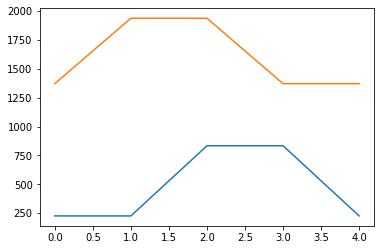

In [21]:
import matplotlib.pyplot as plt
plt.plot(hmi_ar_query_df.iloc[0].pix_harp_bbox)

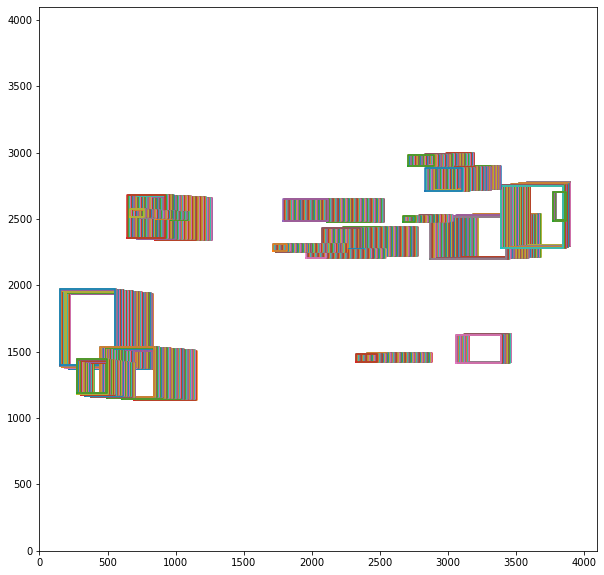

In [35]:


# ax.legend()      